<a href="https://colab.research.google.com/github/sharifkaiser/DL_colab/blob/master/facial_expression_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install kaggle # api for downloading dataset
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.15  # tf 2.0 does not support quantization aware training 
except Exception:
  pass

import tensorflow as tf
tf.enable_eager_execution() # this is must for post training quantization

from __future__ import absolute_import, division, print_function, unicode_literals

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15  # tf 2.0 does not support quantization aware training`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
# strategy: I have uploaded the csv file to google drive, then mounted 
# drive in colab and then converted csv file into images
# mount google drive in colab
from google.colab import drive
drive.mount('/content/drive') # this is saved under /content/drive dir

!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data


In [ ]:
# convert from csv to image
import os
import argparse
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image

# initialize global variables
TRAIN_DIR = ''
TEST_DIR = ''

# declare dictionary for readability
Emotion = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

# kaggle facial expression recognition dataset contains 48*48 pixel greyscale images
IMG_WIDTH = 48
IMG_HEIGHT = 48


def csv_to_images(source):

    data = pd.read_csv(source)  # read file
    # see_data(data)    # see the csv data to get an idea
    _make_dir()
 
    for index, row in data.iterrows():
        img =_create_img(row['pixels'])

        # Save image under training folder
        # python does not have switch case, so use if elif !
        img_path = get_img_dir(int(row['emotion']), row['Usage'], index)
        img.save(img_path)

def _create_img(pixels):
    array_pixel = str(pixels).split()    # contains list of strings
    array = np.array(array_pixel, dtype=np.uint8)   # convert list to array(8bit int) since all pixels are unsigned ints
    array = array.reshape((IMG_WIDTH, IMG_HEIGHT))  # reshape to make proper dimensions
    
    # fromarray modes ref: https://pillow.readthedocs.io/en/3.1.x/handbook/concepts.html#concept-modes
    return Image.fromarray(array, 'L')   # create image, L means 8 bit pixels, grey
    # img.save('my.png')
    # img.show()
def get_img_dir(emotion_type, img_type, index):
    parent_dir = '' # default value
    if str(img_type) == 'Training':
        parent_dir = TRAIN_DIR
        # save image inside train directory
    else:
        parent_dir = TEST_DIR
        # save image inside test directory

    subdir_name = Emotion[emotion_type]
    return os.path.join(parent_dir, subdir_name + "/" + str(index) +".png")

def see_data(data):
    print(data.head) # to see the data, has 3 cols: emotion, pixels, Usage
    # see unique values for emotion and usage column to understand what's going on
    print(data.emotion.unique())    # 0,1,2,3,4,5,6 => 7 emotions in total
    print(data.Usage.unique())  # Training, PublicTest, PrivateTest
    print(data.groupby(['Usage']).size()) # PrivateTest 3589, PublicTest 3589, Training 28709
    # From above commented code, we see 20% test data(private and public), and 80% train data.
    
    pixels = data.head(1).pixels   # array that contains pixel values of the first 10 rows
    for row in pixels:
        print(len(str(row).split()))    # 2304 pixels per row = 48*48 (split returns a list)

def _make_dir():
    ##################################################################################
    # from kaggle dataset, the emotions are: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
    # We will create directory like below:
    # face_images/
    #     train/
    #         angry/
    #         disgust/
    #         fear/
    #         happy/
    #         neutral/
    #         sad/
    #         surprise/
    #     test/
    #         angry/
    #         disgust/
    #         fear/
    #         happy/
    #         neutral/
    #         sad/
    #         surprise/
    ##################################################################################

    current_file_path = os.path.dirname(Path().absolute()) # in colab, __file__ does not work: https://stackoverflow.com/questions/3430372/how-do-i-get-the-full-path-of-the-current-files-directory
    base_dir = os.path.join(current_file_path, "face_images") # first argument is an absolute path
    global TRAIN_DIR, TEST_DIR  # global keyword is used to make chnages to the global var
    TRAIN_DIR = os.path.join(base_dir, "train/")
    TEST_DIR = os.path.join(base_dir, "test/")
    
    # Create train directories
    # ref for Path: https://docs.python.org/3/library/pathlib.html#pathlib.PurePath
    # parents=true means missing parents will be added, exist_ok true means it does not throw exception if dir already exists
    Path(TRAIN_DIR + "angry/").mkdir(parents=True, exist_ok=True)
    Path(TRAIN_DIR + "disgust/").mkdir(parents=True, exist_ok=True)
    Path(TRAIN_DIR + "fear/").mkdir(parents=True, exist_ok=True)
    Path(TRAIN_DIR + "happy/").mkdir(parents=True, exist_ok=True)
    Path(TRAIN_DIR + "neutral/").mkdir(parents=True, exist_ok=True)
    Path(TRAIN_DIR + "sad/").mkdir(parents=True, exist_ok=True)
    Path(TRAIN_DIR + "surprise/").mkdir(parents=True, exist_ok=True)

    # Create test directories
    Path(TEST_DIR + "angry/").mkdir(parents=True, exist_ok=True)
    Path(TEST_DIR + "disgust/").mkdir(parents=True, exist_ok=True)
    Path(TEST_DIR + "fear/").mkdir(parents=True, exist_ok=True)
    Path(TEST_DIR + "happy/").mkdir(parents=True, exist_ok=True)
    Path(TEST_DIR + "neutral/").mkdir(parents=True, exist_ok=True)
    Path(TEST_DIR + "sad/").mkdir(parents=True, exist_ok=True)
    Path(TEST_DIR + "surprise/").mkdir(parents=True, exist_ok=True)

##

print('before creating images')
csv_to_images('/content/drive/My Drive/dataset/fer2013.csv')  # this file exists in my google drive
print('success!')

before creating images
success!


In [ ]:
# # configure kaggle api, it is not necessary in PC. 
# # For ubuntu e.g. local PC, just copy paste kaggle.json file in ~/.kaggle/
# !mkdir ~/.kaggle
# !touch ~/.kaggle/kaggle.json
# api_token = {"username":"akmsharifkaiser","key":"8c9a04ae5b876fb2b196e76064a3afd6"}

# import json

# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 ~/.kaggle/kaggle.json



Using TensorFlow backend.


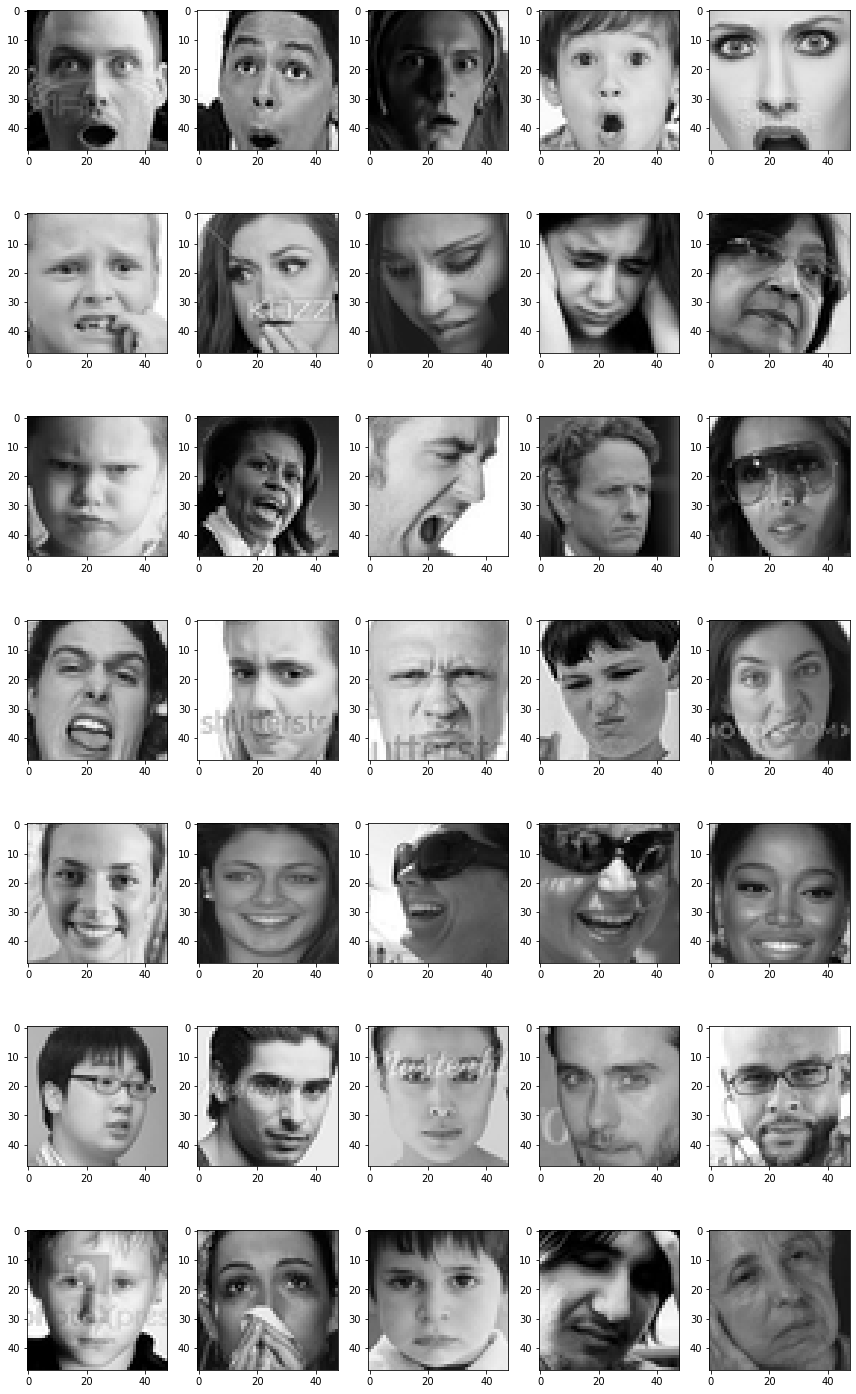

3171 surprise images
4097 fear images
3995 angry images
436 disgust images
7215 happy images
4965 neutral images
4830 sad images


In [ ]:
# For testing: display some images for every different expression to see if data is OK

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
BASE_DIR = "../face_images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(BASE_DIR + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(BASE_DIR + "train/" + expression + "/" +os.listdir(BASE_DIR + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

# count number of train images for each expression
for expression in os.listdir(BASE_DIR + "train"):
    print(str(len(os.listdir(BASE_DIR + "train/" + expression))) + " " + expression + " images")


In [ ]:
# This code block does image augmentation on train images to get better result
# augmentation like random rotation, flip, zoom etc. gives more variety to the model,
# which helps to the fact that model is not memorizing images
# Augmented data directory is the same as train and test directory, the model will 
# run many times and each time it will see a randomly augmented image which will 
# ease generalizing the train data
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMAGE_RES = 48  # for this dataset img shape is 48*48
# IMAGE_RES = 299 # for inception v3
# IMAGE_RES = 224 # for mobilenet v2

BASE_DIR = "../face_images/"
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')


# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# image augmentation makes it worse, so no augmentation
# image_gen_train = ImageDataGenerator(
#   rescale=1./255, # rescaling is necessary, ref: https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn
#   rotation_range=45,
#   width_shift_range=0.10,
#   height_shift_range=0.10,
#   shear_range=0.1,
#   horizontal_flip=True,
#   fill_mode='nearest'
# )
# image_gen_val = ImageDataGenerator(rescale=1./255) 

# Try with no augmentation
# image_gen_train = ImageDataGenerator(rescale=1./255)
# image_gen_val = ImageDataGenerator(rescale=1./255)
image_gen_train = ImageDataGenerator()
image_gen_val = ImageDataGenerator()

# Put It All Together
train_data_gen = image_gen_train.flow_from_directory(
  batch_size=BATCH_SIZE,
  directory=TRAIN_DIR,
  shuffle=True,
  target_size=(IMAGE_RES,IMAGE_RES),
  # color_mode='rgb', # will be converted to 3 channels, for transfer learning
  color_mode='grayscale',
  # class_mode='sparse' # will be 1D integer labels
  class_mode='categorical' # for scratch training
)

augmented_images = [train_data_gen[0][0][1] for i in range(5)]
# augmented_images = [format(train_data_gen.shape[2]) for i in range(5)]
# plotImages(augmented_images)  # See the results

# Create a Data Generator for the Validation Set
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=TEST_DIR,
    shuffle=False,
    target_size=(IMAGE_RES, IMAGE_RES),
    # color_mode='rgb', # will be converted to 3 channels
    color_mode='grayscale',
    # class_mode='sparse', # for transfer learning
    class_mode='categorical' # for scratch training
  )

# print(len(list(train_data_gen)))
# train_data_gen is a tuples of (x, y) where x is a numpy array containing a batch of images
# with shape (batch_size, *target_size, channels) and 
# y is a numpy array of corresponding labels.

# count number of train images for each expression
for expression in os.listdir(BASE_DIR + "train"):
    print(str(len(os.listdir(BASE_DIR + "train/" + expression))) + " " + expression + " images")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
3171 surprise images
4097 fear images
3995 angry images
436 disgust images
7215 happy images
4965 neutral images
4830 sad images


# Train the model without transfer learning


In [ ]:
# Note: we are using keras here. Keras api does not support quantization-aware training, so we
# must use post-training quantization

# This model gives 65% validation accuracy, around 30 epochs brings 60+%
EPOCHS = 50
NUM_CLASSES = 7

from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


# from tensorflow.python.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
# from tensorflow.python.keras.models import Model, Sequential
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.callbacks import ModelCheckpoint

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization()) # standardizes inputs, accelerates training by reducing epoch numbers
model.add(Activation('relu')) # intro non-linear properties, input to output, deeper levels are more generalized
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # random neurons are dropped out during training to minimize overfitting

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(NUM_CLASSES, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# If your train accuracy increases, meanwhile your test accuracy decreases, 
# then this means that you fall into overfitting.

# following code saves if validation accuracy increases from past history
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_data_gen,
                                steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,
                                epochs=EPOCHS,
                                validation_data = val_data_gen,
                                validation_steps = val_data_gen.n//val_data_gen.batch_size
                                # callbacks=callbacks_list
                                )



# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,
#     epochs=EPOCHS,
#     validation_data = val_data_gen,
#     validation_steps = val_data_gen.n//val_data_gen.batch_size,
#     callbacks=callbacks_list
#   )




RuntimeError: ignored

# TODO: Plot Training and Validation Graphs

In the cell below, plot the training and validation accuracy/loss graphs.

NameError: ignored

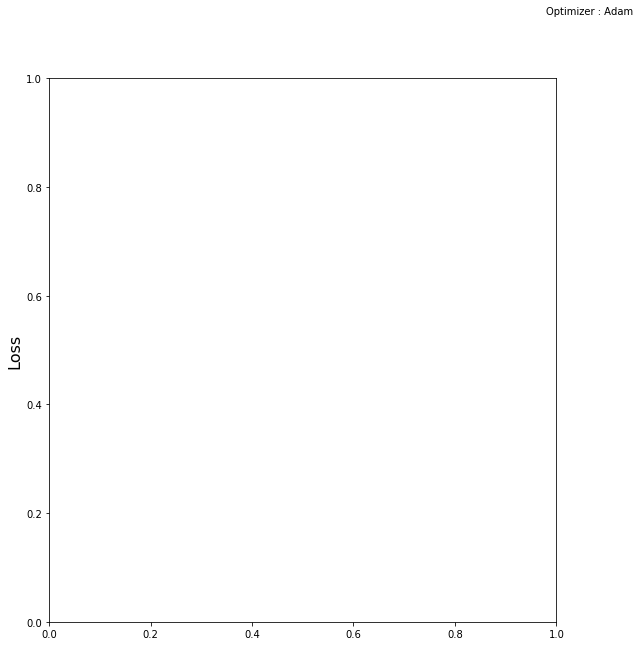

In [ ]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images. 

For both mobilenet and inception, after 1 epoch, divergence happens

# Save model

In the cell below get the label names from the `dataset info` and convert them into a NumPy array. Print the array to make sure you have the correct label names.

In [ ]:
# print(dataset_info.compute_dynamic_properties)
import time

t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1580299770.h5


NameError: ignored

### Load model

In the cell below, use the `next()` function to create an `image_batch` and its corresponding `label_batch`. Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. Then use the `np.argmax()` function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [ ]:
export_path_keras = '/content/drive/My Drive/models/model_weights.h5' # load from drive
import tensorflow_hub as hub
loaded_model = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

loaded_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
__________________________

### Prediction

In the cell below, print the true labels and the indices of predicted labels.

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
import cv2

TARGET_RES = 48

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
# class_names = val_data_gen.class_indices.keys()

base_path = '/content/drive/My Drive/models/fer prediction google images/'
happy_path = base_path + 'happy/'
angry_path = base_path + 'angry/'
disgust_path = base_path + 'disgust/'
surprise_path = base_path + 'surprise/'
sad_path = base_path + 'sad/'

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255  # sample input should be float32 to match with tflite converter
   np_image = transform.resize(np_image, (TARGET_RES, TARGET_RES, 1))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

# def load(filename):
#   np_image = cv2.imread(filename)
#   np_image = np.array(np_image).astype('float32')/255
#   np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2GRAY)
#   roi = cv2.resize(np_image, (48, 48))
#   img = roi[np.newaxis, :, :, np.newaxis]
#   return img

# test code below:
happy_man = load(happy_path + 'man.jpg') # happy man
happy_baby1 = load(happy_path + 'baby1.jpeg')
happy_baby2 = load(happy_path + 'baby2.jpg')
happy_woman = load(happy_path + 'woman.jpg')
angry_man = load(angry_path + 'man.jpg')
angry_woman = load(angry_path + 'woman.jpg')
angry_baby = load(angry_path + 'baby.jpg')
disgust_man = load(disgust_path + 'man.jpg')
disgust_woman = load(disgust_path + 'woman.jpg')
disgust_baby = load(disgust_path + 'baby.jpg')
surprised_man = load(surprise_path + 'man.jpg')
surprised_woman = load(surprise_path + 'woman.jpeg')
surprised_baby = load(surprise_path + 'baby.jpg')
sad_man = load(sad_path + 'man.jpg')
sad_woman = load(sad_path + 'woman.jpg')
sad_baby = load(sad_path + 'baby.jpg')
surprise_train = load(surprise_path + '55.png')
sad_coral = load(happy_path + 'sad80.jpg')  # from coral, it was 80% sad, here, it is 48% neutral

# plt.figure()
# plt.imshow(image6.squeeze(), cmap=plt.cm.binary)

# predictions_array = loaded_model.predict(happy_man) # correct
# predictions_array = loaded_model.predict(happy_baby2) # wrong
# predictions_array = loaded_model.predict(angry_woman) # wrong, sad
# predictions_array = loaded_model.predict(disgust_man) # wrong, sad
# predictions_array = loaded_model.predict(surprised_man) # correct
# predictions_array = loaded_model.predict(surprised_baby) # wrong
# predictions_array = loaded_model.predict(sad_man) # wrong, shows neutral
# predictions_array = loaded_model.predict(sad_baby) # correct
# predictions_array = loaded_model.predict(surprise_train)
predictions_array = loaded_model.predict(happy_baby1)

confidence = f"{100*np.max(predictions_array):.2f}"
detected_emotion = class_names[np.argmax(predictions_array)]
emotion_with_confidence_output = detected_emotion + ': ' + confidence + '%'

print(predictions_array, emotion_with_confidence_output)
# print(image5.shape)

# predicted_batch = tf.squeeze(predicted_batch) # has (32,2) shape

# axis 0 means rows, axis 1 means cols, axis -1 includes all values
# predicted_ids = np.argmax(predicted_batch, axis=1)
# predicted_class_names = class_names[predicted_ids]
# predicted_class_names

[[7.2155730e-05 1.9262693e-08 2.3543891e-04 9.9740666e-01 1.2597096e-03
  3.5820549e-04 6.6781614e-04]] Happy: 99.74%


# Save model and export

In [ ]:
# We don't need to convert to pb as we found another way to convert directly from .h5 file
# export_dir = "exp_saved_model" # export directory for saving

# # saves the model to RPS_SAVED_MODEL directory as .pb file 
# tf.saved_model.save(loaded_model, export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: exp_saved_model/assets


In [ ]:
# https://stackoverflow.com/questions/57877959/what-is-the-correct-way-to-create-representative-dataset-for-tfliteconverter
BATCH_SIZE = 32

def load_img_tflite(filename):
  np_image = cv2.imread(filename)
  np_image = np.array(np_image).astype('float32')/255
  np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2GRAY)
  roi = cv2.resize(np_image, (48, 48))
  img = roi[np.newaxis, :, :, np.newaxis]
  return img

def representative_dataset_gen():
  loaded_image = load_img_tflite(happy_path + 'man.jpg')
  img = tf.data.Dataset.from_tensor_slices(loaded_image).batch(1)  # convert to iterable tensor slice
  # print(img)
  # num_calibration_steps = 10
  for i in img.take(BATCH_SIZE):
    yield [i]


# converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# using keras model converter, directly from .h5 file
converter  = tf.lite.TFLiteConverter.from_keras_model_file('/content/drive/My Drive/models/model_weights.h5')
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen

# following code is for edgetpu support full int quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_model = converter.convert()

open("fer.tflite", "wb").write(tflite_quant_model)

4511296

In [ ]:
# Run tflite inference for testing
import numpy as np
import cv2

def load_img_tflite(filename):
  np_image = cv2.imread(filename)
  np_image = np.asarray(np_image, dtype="float32" )/255
  np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2GRAY)
  cvuint8 = cv2.convertScaleAbs(np_image)
  roi = cv2.resize(cvuint8, (48, 48))
  img = roi[np.newaxis, :, :, np.newaxis]
  return img

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/My Drive/models/fer1.tflite")


interpreter.allocate_tensors()

# first allocate_tensors and then input, output
# https://www.tensorflow.org/lite/guide/inference
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_index = input_details[0]["index"]
output_index = output_details[0]["index"]

input_shape = input_details[0]['shape']

print (input_details, output_details)

# Gather results for the randomly sampled test images
# predictions = []
test_labels = []
test_images = []

sad_coral = load_img_tflite(happy_path + 'sad80.jpg')  # from coral, it was 80% sad, here, it is 48% neutral


# ref: https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter
interpreter.set_tensor(input_index, sad_coral)  # sad_coral is actual input image
interpreter.invoke()  # this invokes the inference
predictions = interpreter.get_tensor(output_index)
# test_labels.append(label[0])
# test_images.append(np.array(img))

# Get input and output tensors.
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
print(predictions)
print(predictions.argmax())
print(predictions.max())
# print(str(np.argmax(predictions[0])))
# confidence = f"{100*np.max(predictions[0]):.2f}"
# print(confidence)


[{'name': 'conv2d_1_input', 'index': 27, 'shape': array([ 1, 48, 48,  1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003730571595951915, 0)}] [{'name': 'Identity', 'index': 28, 'shape': array([1, 7], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0)}]
[[122   1  21   5  25  58  23]]
0
122


In [ ]:
# !sudo apt-get update
# !sudo apt install libedgetpu1-std # edgetpu runtime installation
!sudo apt-get install edgetpu
# !python3 -m pip install libedgetpu1-std
!lsb_release -a  # check ubuntu version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package edgetpu
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic


In [ ]:
# install tflite runtime
!pip3 install https://dl.google.com/coral/python/tflite_runtime-2.1.0-cp36-cp36m-linux_x86_64.whl
# !python --version

     |████████████████████████████████| 1.9MB 1.1MB/s 


In [ ]:
# This is for testing tflite edgetpu version
import numpy as np
import cv2
import tflite_runtime.interpreter as tflite

def load_img_tflite(filename):
  np_image = cv2.imread(filename)
  np_image = cv2.cvtColor(np_image, cv2.COLOR_BGR2GRAY)  
  roi = cv2.resize(np_image, (48, 48))
  img = roi[np.newaxis, :, :, np.newaxis]
  return img

# Load TFLite model and allocate tensors.
model_path="/content/drive/My Drive/models/fer_edgetpu.tflite"
interpreter = tflite.Interpreter(model_path, experimental_delegates=[tflite.load_delegate('libedgetpu.so.1')])
interpreter.allocate_tensors()

# first allocate_tensors and then input, output
# https://www.tensorflow.org/lite/guide/inference
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_index = input_details[0]["index"]
output_index = output_details[0]["index"]

input_shape = input_details[0]['shape']

print (input_details, output_details)

# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

sad_coral = load_img_tflite(happy_path + 'sad80.jpg')  # from coral, it was 80% sad, here, it is 48% neutral


# ref: https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter
interpreter.set_tensor(input_index, sad_coral)  # sad_coral is actual input image
interpreter.invoke()  # this invokes the inference
predictions.append(interpreter.get_tensor(output_index))
# test_labels.append(label[0])
# test_images.append(np.array(img))

# Get input and output tensors.
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
print(predictions)
print(str(np.argmax(predictions[0])))
confidence = f"{100*np.max(predictions[0]):.2f}"
print(confidence)

OSError: ignored

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()
